# Life Expectancy by Zip Code

The following analysis evaluates life expectancy in Detroit by looking at various factors across zip codes.

In [100]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline
# Socrata will allow us to import json files from data.detroitmi.gov
import requests
from sodapy import Socrata

dataframes = {
    'life_expec':'xiz8-6a6u',
    'crime_stats': '9i6z-cm98',
    'housing': 'snut-x2sy',
    'health': 'upia-wkjr'
}

In [101]:
import warnings
warnings.filterwarnings('ignore')

# Load the data
# First, try Socrata's API
socrata_client = Socrata("data.detroitmi.gov", None)
# If that fails, use a general request with verify = False. Corporate VPNs may block API requests.
session = requests.Session()

dict_of_df = {}
for key,value in dataframes.items():
    try:
        json_file = socrata_client.get(value)
    except:
        url = "https://data.detroitmi.gov/resource/"+value+".json"
        connect = session.get(url, verify=False)
        json_file = connect.json()
        
    df = pd.DataFrame.from_records(json_file)
    
    name = 'df_'+key
    dict_of_df[name] = df

# Evaluating Life Expectancy alone

We expect to see similar life expectancies throughout Detroit. However, Detroit is a diverse city when it comes to income, crime, and other factors when comparing one zip code to another. Because of this, we expect to see differences in life expectancy.

In [102]:
df_life_expec = dict_of_df['df_life_expec']
df_life_expec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
aland10       65 non-null object
awater10      65 non-null object
geoid10       65 non-null object
intptlat10    65 non-null object
intptlon10    65 non-null object
life_exp      65 non-null object
zipcode       65 non-null object
dtypes: object(7)
memory usage: 3.6+ KB


In [103]:
df_life_expec['life_exp'] = df_life_expec['life_exp'].astype(float)
df_life_expec['awater10'] = df_life_expec['awater10'].astype(float)
df_life_expec['aland10'] = df_life_expec['aland10'].astype(float)

In [104]:
df_life_expec.set_index('zipcode', inplace=True)
df_life_expec.head()

,aland10,awater10,geoid10,intptlat10,intptlon10,life_exp
zipcode,,,,,,
48236,19463663.0,3357791.0,2648236,42.4253730,-82.8931944,82.0
48213,16923386.0,0.0,2648213,42.3979308,-82.9952131,70.0
48216,5747286.0,0.0,2648216,42.3264844,-83.0787461,75.0
48221,14119737.0,2042.0,2648221,42.4269999,-83.1486085,74.0
48215,10395926.0,0.0,2648215,42.3750512,-82.9543435,70.0


There are less than 65 zip codes in Detroit (the data set includes all of Wayne County), so let's limit it to only Detroit using the zip codes shape file.

In [105]:
import geopandas as gpd

# Detroit zip codes shape files from https://data.detroitmi.gov/Government/City-of-Detroit-Zip-Code-Boundaries/ruqh-3htk
geo_data = gpd.GeoDataFrame.from_file('DetroitZipCodes.shp')
geo_data.set_index('zipcode', inplace=True)
df = pd.merge(geo_data, df_life_expec, left_index=True, right_index=True, how='inner')
df.head()

,geometry,aland10,awater10,geoid10,intptlat10,intptlon10,life_exp
zipcode,,,,,,,
48201,POLYGON ((-83.07769989730168 42.35253979022775...,5193540.0,0.0,2648201,42.3470206,-83.0601841,69.0
48202,POLYGON ((-83.10059046484989 42.38864008879628...,8616314.0,0.0,2648202,42.3747864,-83.0777179,71.0
48203,POLYGON ((-83.13333046224123 42.44622964316824...,20756114.0,18585.0,2648203,42.4207361,-83.1043384,70.0
48204,"POLYGON ((-83.1686603932292 42.38066977506995,...",12980500.0,0.0,2648204,42.3658122,-83.1429352,71.0
48205,POLYGON ((-83.01397012662339 42.41972011813695...,16531627.0,0.0,2648205,42.4331562,-82.9811418,70.0


In [106]:
df.describe()

,aland10,awater10,life_exp
count,3.100000e+01,3.100000e+01,31.000000
mean,1.406401e+07,2.124260e+05,72.129032
std,5.518056e+06,6.587049e+05,2.655082
min,3.197600e+06,0.000000e+00,69.000000
25%,1.004572e+07,0.000000e+00,70.500000
50%,1.411974e+07,0.000000e+00,71.000000
75%,1.721250e+07,2.249650e+04,73.000000
max,2.519332e+07,3.357791e+06,82.000000


As we can see, the average life expectancy for the 31 zip codes is just over 72 years. The median is 71 years, with a min of 69 years and a max of 82 years. The difference of 13 years between the top and bottom zip codes is surprising!

In order to get a better idea of how life expectancy differs between zip codes, we need to look at the distribution. Any variation from a standard normal distribution will hopefully be explained in the following analysis. 

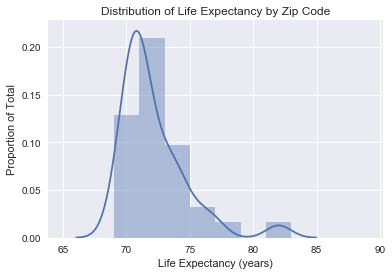

In [107]:
xlabel = 'Life Expectancy (years)'
ylabel = 'Proportion of Total'
title = 'Distribution of Life Expectancy by Zip Code'

plt = sns.distplot(df['life_exp'], bins = range(65,90,2)).set(xlabel = xlabel, ylabel = ylabel, title = title)

The distribution appears to be skewed toward the lower end of life expectancy. We are unsure why as of now, but based on our knowledge of poverty levels in Detroit (and most ubran areas in general), this is not out of line. Visualizing the data on the map shows another way to view the differences between populations. The next step will be to compare these plots with plots containing other values.

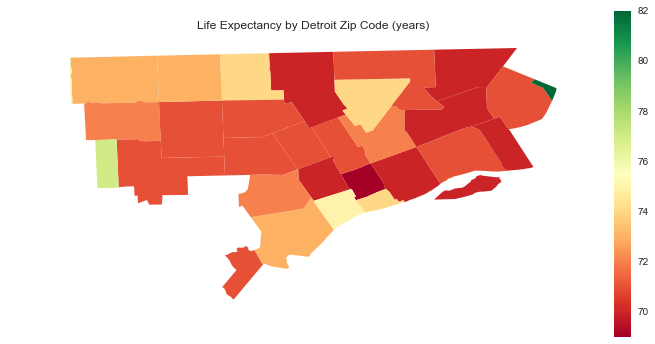

In [108]:
plt = df.plot(column='life_exp', cmap='RdYlGn', legend=True, figsize=(12,6))
plt.set_title('Life Expectancy by Detroit Zip Code (years)')
plt.set_axis_off()

# Crime Statistics

We will now evaluate the effect of crime on the life expectancy. We expect that increased crime will lead to a lower life expectancy, especially in the cases where zip codes have high instances of violent crime.

To start, we pull the all crime incidents reported by the Detroit Police Department from December 6, 2016 until November 6, 2017

In [109]:
df_crime_stats = dict_of_df['df_crime_stats']

We then summarize by zip code:

In [110]:
df_crime_stats['zipcode']=df_crime_stats['zip_code']
df_crime_stats['one'] = 1

offense_category = df_crime_stats['offense_category'].astype(str)
offense_category.name = 'Offense Category'
byzip_cr = df_crime_stats.groupby(['zipcode', offense_category])['one'].sum().unstack().fillna(0)

byzip_cr['Total Crime Incidents']=byzip_cr.sum(axis=1)

byzip_cr.describe()

Offense Category,AGGRAVATED ASSAULT,ARSON,ASSAULT,BURGLARY,DAMAGE TO PROPERTY,DANGEROUS DRUGS,DISORDERLY CONDUCT,EXTORTION,FAMILY OFFENSE,FORGERY,...,OTHER,ROBBERY,RUNAWAY,SEX OFFENSES,SEXUAL ASSAULT,SOLICITATION,STOLEN PROPERTY,STOLEN VEHICLE,WEAPONS OFFENSES,Total Crime Incidents
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.500000,0.700000,3.966667,3.666667,2.900000,0.633333,0.166667,0.066667,0.833333,0.066667,...,0.133333,1.333333,0.166667,2.066667,0.133333,0.033333,0.200000,3.233333,0.533333,32.866667
std,2.885756,0.987857,3.418846,3.536347,2.171127,0.927857,0.461133,0.253708,1.315251,0.253708,...,0.434172,1.124441,0.592093,7.696543,0.345746,0.182574,0.484234,3.047705,1.041661,23.488417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.000000,15.250000
50%,1.500000,0.000000,4.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,27.000000
75%,4.000000,1.000000,5.750000,5.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.750000,45.750000
max,12.000000,4.000000,12.000000,15.000000,9.000000,4.000000,2.000000,1.000000,5.000000,1.000000,...,2.000000,3.000000,3.000000,42.000000,1.000000,1.000000,2.000000,13.000000,4.000000,78.000000


and join it to the existing data:

In [111]:
df_cr = df.join(byzip_cr, how='left')
df_cr

,geometry,aland10,awater10,geoid10,intptlat10,intptlon10,life_exp,AGGRAVATED ASSAULT,ARSON,ASSAULT,...,OTHER,ROBBERY,RUNAWAY,SEX OFFENSES,SEXUAL ASSAULT,SOLICITATION,STOLEN PROPERTY,STOLEN VEHICLE,WEAPONS OFFENSES,Total Crime Incidents
zipcode,,,,,,,,,,,,,,,,,,,,,
48201,POLYGON ((-83.07769989730168 42.35253979022775...,5193540.0,0.0,2648201,42.3470206,-83.0601841,69.0,1.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,27.0
48202,POLYGON ((-83.10059046484989 42.38864008879628...,8616314.0,0.0,2648202,42.3747864,-83.0777179,71.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.0
48203,POLYGON ((-83.13333046224123 42.44622964316824...,20756114.0,18585.0,2648203,42.4207361,-83.1043384,70.0,2.0,0.0,1.0,...,0.0,0.0,0.0,42.0,0.0,0.0,0.0,3.0,2.0,56.0
48204,"POLYGON ((-83.1686603932292 42.38066977506995,...",12980500.0,0.0,2648204,42.3658122,-83.1429352,71.0,1.0,0.0,4.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,22.0
48205,POLYGON ((-83.01397012662339 42.41972011813695...,16531627.0,0.0,2648205,42.4331562,-82.9811418,70.0,4.0,2.0,8.0,...,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,77.0
48206,"POLYGON ((-83.1305299666072 42.38420027465364,...",8095663.0,0.0,2648206,42.3751234,-83.1078968,71.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,23.0
48207,POLYGON ((-83.05457991345152 42.36087000487222...,16061703.0,521193.0,2648207,42.3496544,-83.0189600,70.0,3.0,1.0,3.0,...,0.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,29.0
48207,POLYGON ((-82.99704030416588 42.33969982690309...,16061703.0,521193.0,2648207,42.3496544,-83.0189600,70.0,3.0,1.0,3.0,...,0.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,29.0
48208,POLYGON ((-83.11103012926353 42.35622977628543...,8190764.0,0.0,2648208,42.3484911,-83.0919366,70.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0


# Federally Qualified Health Centers

We repeat the same steps for the number of health centers as we did with crime:

In [112]:
df_health = dict_of_df['df_health']

df_health['zipcode']=df_health['zip_code']
df_health['one'] = 1

byzip_hlth = df_health.groupby(['zipcode'])['one'].sum()
byzip_hlth.index

df_health = df_cr.join(byzip_hlth, how='left')
df_health['Health Centers'] = df_health['one'].fillna(0)
df_health['Total Crimes'] = df_health['Total Crime Incidents'].fillna(0)
df_health

,geometry,aland10,awater10,geoid10,intptlat10,intptlon10,life_exp,AGGRAVATED ASSAULT,ARSON,ASSAULT,...,SEX OFFENSES,SEXUAL ASSAULT,SOLICITATION,STOLEN PROPERTY,STOLEN VEHICLE,WEAPONS OFFENSES,Total Crime Incidents,one,Health Centers,Total Crimes
zipcode,,,,,,,,,,,,,,,,,,,,,
48201,POLYGON ((-83.07769989730168 42.35253979022775...,5193540.0,0.0,2648201,42.3470206,-83.0601841,69.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,0.0,27.0,5.0,5.0,27.0
48202,POLYGON ((-83.10059046484989 42.38864008879628...,8616314.0,0.0,2648202,42.3747864,-83.0777179,71.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,1.0,23.0
48203,POLYGON ((-83.13333046224123 42.44622964316824...,20756114.0,18585.0,2648203,42.4207361,-83.1043384,70.0,2.0,0.0,1.0,...,42.0,0.0,0.0,0.0,3.0,2.0,56.0,1.0,1.0,56.0
48204,"POLYGON ((-83.1686603932292 42.38066977506995,...",12980500.0,0.0,2648204,42.3658122,-83.1429352,71.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,2.0,22.0,NaN,0.0,22.0
48205,POLYGON ((-83.01397012662339 42.41972011813695...,16531627.0,0.0,2648205,42.4331562,-82.9811418,70.0,4.0,2.0,8.0,...,1.0,0.0,0.0,1.0,1.0,1.0,77.0,NaN,0.0,77.0
48206,"POLYGON ((-83.1305299666072 42.38420027465364,...",8095663.0,0.0,2648206,42.3751234,-83.1078968,71.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,2.0,1.0,23.0,NaN,0.0,23.0
48207,POLYGON ((-83.05457991345152 42.36087000487222...,16061703.0,521193.0,2648207,42.3496544,-83.0189600,70.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,2.0,0.0,29.0,NaN,0.0,29.0
48207,POLYGON ((-82.99704030416588 42.33969982690309...,16061703.0,521193.0,2648207,42.3496544,-83.0189600,70.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,2.0,0.0,29.0,NaN,0.0,29.0
48208,POLYGON ((-83.11103012926353 42.35622977628543...,8190764.0,0.0,2648208,42.3484911,-83.0919366,70.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,10.0,NaN,0.0,10.0


We predict that the zip codes with more crime will have a lower life expectancy, and the opposite should be true for zip codes with a lower number of federally qualified health centers.

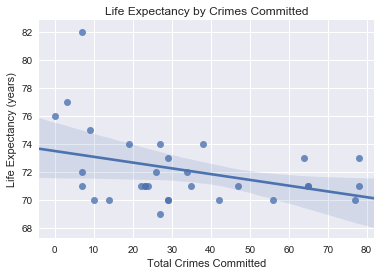

In [113]:
ylabel = 'Life Expectancy (years)'
xlabel = 'Total Crimes Committed'
title = 'Life Expectancy by Crimes Committed'

plt = sns.regplot(x=df_health['Total Crimes'], y=df_health['life_exp']).set(xlabel = xlabel, ylabel = ylabel, title = title)

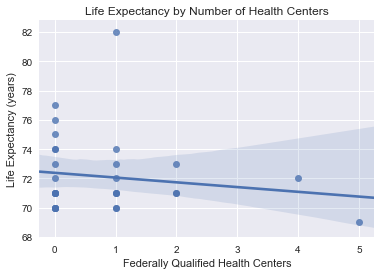

In [114]:
ylabel = 'Life Expectancy (years)'
xlabel = 'Federally Qualified Health Centers'
title = 'Life Expectancy by Number of Health Centers'

plt = sns.regplot(x=df_health['Health Centers'], y=df_health['life_exp']).set(xlabel = xlabel, ylabel = ylabel, title = title)

As we can see, the number of crimes committed appears to be inversely correlated with life expectancy within a zip code. In other words, when more crimes are committed, we expect the life expectancy to decrease. This is within expectation.

However, the number of Federally Qualified Health Centers also appears to show a negative correlation with life expectancy within a zip code. This does not fit our initial hypothesis, but futher investigation is necessary before any conclusions may be drawn.

# Conclusions

In conclusion, the life expectancy varies more between zip codes than initially expected. There are many factors that can affect this, but the two touched on here show that the number of crimes committed and the number of federally qualified health centers are both higher in areas with a lower life expectancy. Adding in population statistics such as number of people, average and median age, poverty rate, income inequality, and other factors will provide a better explanation of the differences in life expectancy.

## Appendix: Three more charts...

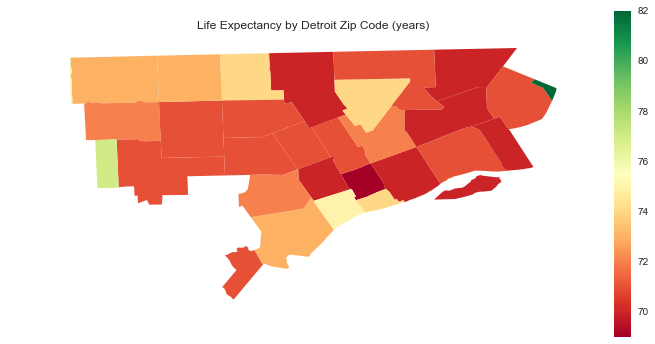

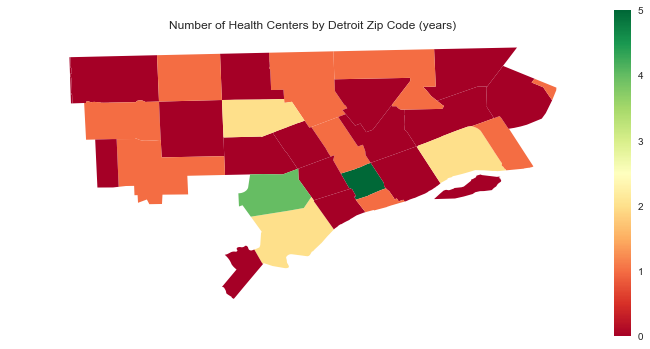

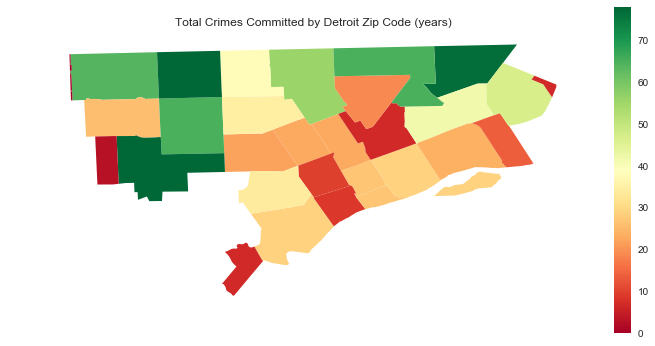

In [117]:
plt = df_health.plot(column='life_exp', cmap='RdYlGn', legend=True, figsize=(12,6))
plt.set_title('Life Expectancy by Detroit Zip Code (years)')
plt.set_axis_off()

plt2 = df_health.plot(column='Health Centers', cmap='RdYlGn', legend=True, figsize=(12,6))
plt2.set_title('Number of Health Centers by Detroit Zip Code (years)')
plt2.set_axis_off()

plt3 = df_health.plot(column='Total Crimes', cmap='RdYlGn', legend=True, figsize=(12,6))
plt3.set_title('Total Crimes Committed by Detroit Zip Code (years)')
plt3.set_axis_off()